### 記事本
#### I. 需要解決的問題
* 處理 Imbalance 問題
* Table test
* 做 Cross Validation
* 嘗試使用 LightGBM
* 嘗試做 feature selection 後，再做 SMOTE -> t-SNE
#### II. 寫報告的流程
1. 先點出樣本不平衡問題
2. 使用SMOTE解決樣本不平衡問題，繪製出增加樣本前後的樣本變化量，並且使用 t-SNE 分析新增樣本的合理性
3. （特徵選擇）
4. 比較使用 SMOTE 前後在 test dataset 上的表現（accuracy, ROC-AUC）

#### III. 流程
1. Feature selection
2. SMOTE -> t-SNE
3. Cross validation https://blog.csdn.net/liuxiao214/article/details/79019901

In [490]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold

In [491]:
GDSC_TCGA_Docetaxel = pd.read_csv('data/GDSC_TCGA_Docetaxel/GDSC_TCGA_Docetaxel.csv')
GDSC_TCGA_Docetaxel.columns.values[0] = "CELL_LINE_NAME"
GDSC_TCGA_Docetaxel

,CELL_LINE_NAME,IC50,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,MC-CAR,0.007317,-1.771265,0.610600,0.401711,1.106639,0.892463,5.280920,-0.448906,-0.603844,...,0.014012,-1.774443,-0.564932,0.745884,0.067401,0.071798,-0.795007,0.208152,0.920566,-0.108400
1,PFSK-1,0.001761,0.589651,-0.481344,-0.102904,0.166903,0.033028,-0.297542,2.267238,-1.950722,...,-0.414321,0.132181,0.459550,1.231701,0.095877,-0.506559,0.573636,-0.052642,-1.414468,-0.830343
2,ES5,0.001184,0.824778,-0.140724,-0.000743,0.908738,0.324213,-0.372808,0.545903,-2.270533,...,-0.555727,0.054253,-0.706297,1.045812,-0.198301,-0.375373,0.997468,-0.444827,1.287275,0.093119
3,ES7,0.000550,0.876942,5.304997,-0.407386,-0.529356,-0.467901,-0.432257,-0.618523,-1.732870,...,-0.555933,-0.124543,0.173441,0.900766,0.194683,-0.329766,1.099872,-0.097426,-0.915754,-0.337166
4,EW-11,0.001664,0.907022,0.544350,0.447872,0.064185,1.012554,-0.206224,1.601955,-2.168519,...,-0.468249,-0.933497,-0.171144,0.356018,-0.742446,-0.481873,0.562201,-0.229934,0.659579,-1.023215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,RCC-AB,0.013015,0.498120,-0.588126,-0.078362,-0.204308,1.648799,-0.328670,1.388902,1.055700,...,1.791280,-0.772050,-0.998507,-0.517322,0.335512,-0.396386,-0.317182,-0.412571,-0.283819,2.256465
846,RCC-MF,0.026358,0.522648,-0.515479,0.071471,-1.501136,-0.977670,-0.383396,1.748097,0.748840,...,0.754285,1.171674,1.267953,0.239368,0.253742,-0.458750,0.356426,-0.293842,-0.722185,-0.124967
847,KMS-11,0.034812,-1.742729,-0.642450,0.526023,0.401107,1.144835,-0.201753,-0.596266,-0.111974,...,-0.262681,-1.134921,0.819662,-0.628280,-0.037454,-0.168049,-1.224777,-0.058288,-0.156636,-0.346016
848,SNU-61,0.162531,0.743705,-0.347487,0.039888,1.756746,0.131114,-0.402442,-0.415835,1.021365,...,1.090940,-0.316082,-1.317266,0.094575,0.097480,-0.244712,-0.725647,0.108508,0.847898,1.846166


In [492]:
'''依照IC50為GDSC_TCGA_Docetaxel加上label'''
GDSC_TCGA_D_train_data_label = np.asarray(GDSC_TCGA_Docetaxel["IC50"]>0.0125)


In [493]:
GDSC_TCGA_D_train_data = GDSC_TCGA_Docetaxel.drop(labels=['CELL_LINE_NAME', 'IC50'], axis=1)
# GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data.assign(RS = RS_bool)
GDSC_TCGA_D_train_data

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,-1.771265,0.610600,0.401711,1.106639,0.892463,5.280920,-0.448906,-0.603844,-0.834682,0.300012,...,0.014012,-1.774443,-0.564932,0.745884,0.067401,0.071798,-0.795007,0.208152,0.920566,-0.108400
1,0.589651,-0.481344,-0.102904,0.166903,0.033028,-0.297542,2.267238,-1.950722,-1.104072,0.867475,...,-0.414321,0.132181,0.459550,1.231701,0.095877,-0.506559,0.573636,-0.052642,-1.414468,-0.830343
2,0.824778,-0.140724,-0.000743,0.908738,0.324213,-0.372808,0.545903,-2.270533,-0.368256,1.829893,...,-0.555727,0.054253,-0.706297,1.045812,-0.198301,-0.375373,0.997468,-0.444827,1.287275,0.093119
3,0.876942,5.304997,-0.407386,-0.529356,-0.467901,-0.432257,-0.618523,-1.732870,-0.126682,1.016972,...,-0.555933,-0.124543,0.173441,0.900766,0.194683,-0.329766,1.099872,-0.097426,-0.915754,-0.337166
4,0.907022,0.544350,0.447872,0.064185,1.012554,-0.206224,1.601955,-2.168519,0.055405,1.565683,...,-0.468249,-0.933497,-0.171144,0.356018,-0.742446,-0.481873,0.562201,-0.229934,0.659579,-1.023215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,0.498120,-0.588126,-0.078362,-0.204308,1.648799,-0.328670,1.388902,1.055700,-0.058142,0.260766,...,1.791280,-0.772050,-0.998507,-0.517322,0.335512,-0.396386,-0.317182,-0.412571,-0.283819,2.256465
846,0.522648,-0.515479,0.071471,-1.501136,-0.977670,-0.383396,1.748097,0.748840,0.833385,-0.686824,...,0.754285,1.171674,1.267953,0.239368,0.253742,-0.458750,0.356426,-0.293842,-0.722185,-0.124967
847,-1.742729,-0.642450,0.526023,0.401107,1.144835,-0.201753,-0.596266,-0.111974,0.150691,0.089586,...,-0.262681,-1.134921,0.819662,-0.628280,-0.037454,-0.168049,-1.224777,-0.058288,-0.156636,-0.346016
848,0.743705,-0.347487,0.039888,1.756746,0.131114,-0.402442,-0.415835,1.021365,0.079219,-1.294155,...,1.090940,-0.316082,-1.317266,0.094575,0.097480,-0.244712,-0.725647,0.108508,0.847898,1.846166


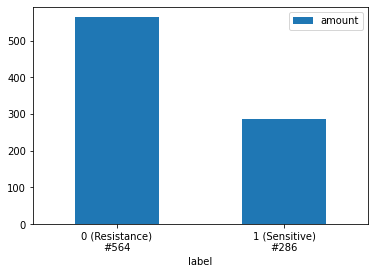

In [494]:
ttt = np.asarray(GDSC_TCGA_D_train_data_label, dtype=int)
ones = np.sum(ttt)
zeros = len(ttt) - ones

df = pd.DataFrame({'label':[f'0 (Resistance)\n#{zeros}', f'1 (Sensitive)\n#{ones}'], 'amount':[zeros, ones]})

ax = df.plot.bar(x='label', y='amount', rot=0)

### 讀取測試資料集

In [495]:
Patients_TCGA_Docetaxel = pd.read_csv('data/GDSC_TCGA_Docetaxel/Patients_TCGA_Docetaxel.csv')
Patients_TCGA_Docetaxel.columns.values[0] = "Patients_ID"
Patients_TCGA_Docetaxel

,Patients_ID,label,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,TCGA.50.5930.01A,0,-0.081350,-0.018003,-0.717931,-1.539410,-1.216847,0.108111,0.289653,0.783037,...,-1.746324,0.257519,0.074542,-0.973352,-0.354552,-0.229879,-0.127647,-0.157220,-0.868103,-0.695200
1,TCGA.53.7624.01A,0,-0.522505,-0.018003,0.184457,1.240316,1.756752,-1.065763,-1.682642,1.859819,...,-0.352620,0.421365,0.074542,1.884520,-0.429709,-0.667936,1.465407,-0.157220,-0.459363,2.629445
2,TCGA.A2.A0CK.01A,1,0.818422,2.330359,-0.890597,-0.038683,-0.328867,-0.157596,0.105049,-0.492415,...,-0.154097,-0.319665,-0.075532,0.299359,-0.098560,0.328741,-0.575729,-0.040781,0.931449,-0.575186
3,TCGA.A2.A3XS.01A,0,1.229073,-0.545507,1.005106,-0.538867,-0.276611,0.080805,-0.172992,-0.178448,...,0.012412,-0.142614,-0.075532,1.229369,4.276112,1.486760,-0.560333,-0.121356,1.316177,-0.575186
4,TCGA.A2.A3XT.01A,1,-1.442696,-0.338689,1.045560,-0.457079,0.980792,2.244373,-0.621860,1.277150,...,-0.096454,-0.155759,-0.075532,0.729400,-0.175587,1.394517,-1.649600,-0.060866,0.857928,0.118705
5,TCGA.A2.A3Y0.01A,1,-0.948059,-0.456627,-1.451546,-1.379153,0.205031,0.210501,-0.743640,-1.095117,...,-0.112815,-0.025107,0.817348,0.025053,-0.222359,0.697818,-1.598057,-0.121356,0.029634,-0.575186
6,TCGA.AC.A2FB.01A,1,0.469781,-0.561535,-1.043632,0.608659,0.062359,0.623068,0.644343,-0.311580,...,2.459230,-0.319665,-0.075532,-0.291696,-0.000966,0.655083,0.089274,-0.046772,-0.901677,1.745231
7,TCGA.BH.A5IZ.01A,1,0.368275,-0.732823,1.260744,-0.762613,1.864362,-0.079273,-1.016461,1.267091,...,0.142332,-0.319665,-0.075532,0.578728,0.482124,1.087226,-1.095904,-0.121356,0.137532,-0.575186
8,TCGA.CG.5725.01A,0,2.342875,0.082565,0.070810,-0.480288,1.293092,-1.961262,-1.309806,-0.653198,...,-1.812188,4.341394,-0.238773,0.579155,-0.222425,-1.580256,-1.164883,-0.437475,1.629596,0.768726
9,TCGA.CN.4731.01A,0,0.503427,-0.056944,0.624364,-0.573450,-0.403624,-0.716342,0.637767,0.451514,...,-0.024197,1.009303,-0.096568,-0.736548,-0.114433,2.257101,0.126918,-0.650059,1.012949,-0.556279


In [496]:
P_TCGA_D_label = Patients_TCGA_Docetaxel[["label"]]
P_TCGA_D_label

,label
0,0
1,0
2,1
3,0
4,1
5,1
6,1
7,1
8,0
9,0


In [497]:
P_TCGA_D_wo_label = Patients_TCGA_Docetaxel.drop(labels=['label', 'Patients_ID'], axis=1)
P_TCGA_D_wo_label

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,SMIM6,SLC35G6,OR4N3P,MRPL46,HPR,MIA,ZNF234,MYH4,LINC00526,KRT18P55
0,-0.081350,-0.018003,-0.717931,-1.539410,-1.216847,0.108111,0.289653,0.783037,0.138750,-0.431759,...,-1.746324,0.257519,0.074542,-0.973352,-0.354552,-0.229879,-0.127647,-0.157220,-0.868103,-0.695200
1,-0.522505,-0.018003,0.184457,1.240316,1.756752,-1.065763,-1.682642,1.859819,1.886379,-0.261790,...,-0.352620,0.421365,0.074542,1.884520,-0.429709,-0.667936,1.465407,-0.157220,-0.459363,2.629445
2,0.818422,2.330359,-0.890597,-0.038683,-0.328867,-0.157596,0.105049,-0.492415,-1.671058,-1.264372,...,-0.154097,-0.319665,-0.075532,0.299359,-0.098560,0.328741,-0.575729,-0.040781,0.931449,-0.575186
3,1.229073,-0.545507,1.005106,-0.538867,-0.276611,0.080805,-0.172992,-0.178448,-0.822245,0.263540,...,0.012412,-0.142614,-0.075532,1.229369,4.276112,1.486760,-0.560333,-0.121356,1.316177,-0.575186
4,-1.442696,-0.338689,1.045560,-0.457079,0.980792,2.244373,-0.621860,1.277150,-0.616460,-0.248031,...,-0.096454,-0.155759,-0.075532,0.729400,-0.175587,1.394517,-1.649600,-0.060866,0.857928,0.118705
5,-0.948059,-0.456627,-1.451546,-1.379153,0.205031,0.210501,-0.743640,-1.095117,0.017669,0.147967,...,-0.112815,-0.025107,0.817348,0.025053,-0.222359,0.697818,-1.598057,-0.121356,0.029634,-0.575186
6,0.469781,-0.561535,-1.043632,0.608659,0.062359,0.623068,0.644343,-0.311580,0.402306,-0.593767,...,2.459230,-0.319665,-0.075532,-0.291696,-0.000966,0.655083,0.089274,-0.046772,-0.901677,1.745231
7,0.368275,-0.732823,1.260744,-0.762613,1.864362,-0.079273,-1.016461,1.267091,-0.015284,0.942918,...,0.142332,-0.319665,-0.075532,0.578728,0.482124,1.087226,-1.095904,-0.121356,0.137532,-0.575186
8,2.342875,0.082565,0.070810,-0.480288,1.293092,-1.961262,-1.309806,-0.653198,1.303685,-0.447866,...,-1.812188,4.341394,-0.238773,0.579155,-0.222425,-1.580256,-1.164883,-0.437475,1.629596,0.768726
9,0.503427,-0.056944,0.624364,-0.573450,-0.403624,-0.716342,0.637767,0.451514,0.181234,0.554887,...,-0.024197,1.009303,-0.096568,-0.736548,-0.114433,2.257101,0.126918,-0.650059,1.012949,-0.556279


### 以 XGBoost 做 Feature Selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

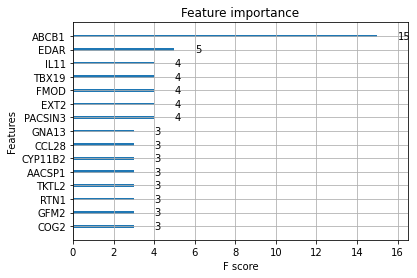

In [498]:
XGBoost_Model = XGBClassifier()
XGBoost_Model.fit(GDSC_TCGA_D_train_data,
                  GDSC_TCGA_D_train_data_label)
plot_importance(XGBoost_Model, max_num_features=15)

In [499]:
feature_importances = XGBoost_Model.feature_importances_
# print(f'Features importance of AdaBoost Model: {feature_importances}')

'''以數量選取 features'''
sort_index = np.argsort(feature_importances)[::-1][:len(feature_importances)]
list_of_selected_features = sort_index[:500]

print(f'使用 XGBoost 所篩選的特徵數量： {np.array(list_of_selected_features).shape} 個')

使用 XGBoost 所篩選的特徵數量： (500,) 個


### 嘗試使用 SMOTE 技巧，解決樣本不平衡問題

In [500]:
smote = SMOTE(random_state=42)
X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
print(len(y_smo))

synthesised_data = pd.DataFrame(X_smo, y_smo)
X_smo

1128


,GPX8,AP3S1,TCEAL3,IMMT,PTPN9,PHF10,SERPINE1,PTGIS,NCMAP,ETV6,...,RUNX2,NSRP1,STK35,DNAJC8,CRISP1,DEK,AHDC1,IFI6,SNRPB,NRSN2
0,-1.420150,0.386853,-0.114386,0.639018,0.018649,-0.325266,-0.664599,0.454638,-0.224953,2.105137,...,-0.750687,0.750504,-1.489794,0.411674,0.708522,0.861483,1.061877,1.259353,0.432679,-0.998949
1,0.572285,0.087745,-1.682273,1.354983,5.130135,-0.214501,0.144149,-0.412828,-0.255422,-1.095360,...,-1.060450,-0.386600,0.524280,0.799403,-0.672974,-0.985796,-0.372948,-0.347575,0.440768,1.321802
2,0.158834,-1.886078,0.552690,0.795379,-0.754120,0.341470,-0.716180,0.244135,-0.115646,-0.946513,...,-0.833310,1.245525,2.343745,0.471983,-1.024280,0.134006,-0.432002,-0.268831,0.280670,-0.139239
3,0.572606,-1.286105,0.410462,0.570145,0.169460,-0.267547,-0.700252,-0.080590,-0.433717,-0.203703,...,-0.610946,0.763049,-0.379428,0.641838,-0.172637,0.108880,1.753101,0.228419,-0.589066,3.222916
4,0.102787,-1.214571,0.516442,0.577600,0.958846,-0.267038,-0.841696,-0.043105,-0.541867,-0.418563,...,-0.967300,1.661122,1.088422,1.469261,1.507778,0.716703,0.904811,-0.518670,0.627689,0.312451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,-1.299618,-0.492741,-1.224341,0.660664,-0.652372,1.652748,-0.686901,0.327603,-0.218251,1.966458,...,-0.573335,0.500259,0.420337,0.379481,-0.491824,0.994784,0.198161,-1.452870,1.179531,-0.548684
1124,0.917055,0.997302,1.080317,-0.414333,0.917816,-0.914688,1.956884,-0.515119,-0.342846,-0.464049,...,-0.015174,0.522863,-1.536554,-0.364311,-0.238648,-0.003421,0.326939,-1.028714,-0.051035,0.922870
1125,0.439272,-0.722959,0.389880,0.191736,-0.932783,0.268480,-0.680948,-0.420070,-0.067770,-0.794954,...,-0.891649,-0.224995,-0.665498,1.041447,-1.128565,0.643403,2.440612,0.900871,-1.028045,-0.016246
1126,-1.336956,-1.678112,0.130487,0.794720,2.005514,0.042210,-0.660919,-0.279070,-0.331840,-1.174951,...,-1.313463,-1.162173,0.111642,-0.654932,0.591828,-0.329726,-1.271962,-0.739328,0.465654,-0.411702


In [501]:
x_min, x_max = X_smo.min(0), X_smo.max(0)
X_smo_norm = (X_smo - x_min) / (x_max - x_min)
y_smo


array([False, False, False, ...,  True,  True,  True])

### 以 t-sne 測試合成資料離散程度

#### 原始資料

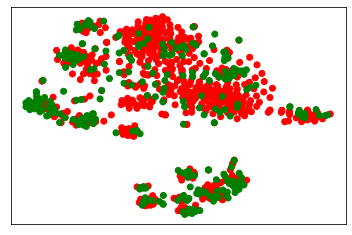

In [502]:
X = GDSC_TCGA_D_train_data
y = GDSC_TCGA_D_train_data_label
tsne = manifold.TSNE(n_components=2, init='random', random_state=501)
X_tsne = tsne.fit_transform(X)

# print("Dimension of original data is {},\n"
#       "Dimension of embedded data is {}.".format(X_smo.shape[-1], X_tsne.shape[-1]))

'''嵌入空間視覺化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

for_tsne = np.vstack((X_norm.T, y)).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'Score'])

colors = {0:'red', 1:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'],
            c=for_tsne_df['Score'].apply(lambda x: colors[x]))

plt.xticks([])
plt.yticks([])
plt.show()

#### 加入合成資料後

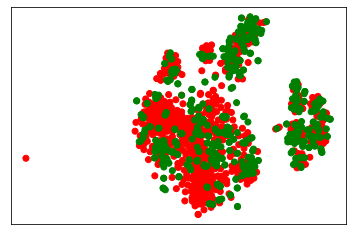

In [503]:
tsne = manifold.TSNE(n_components=2, init='random', random_state=501)
X_tsne = tsne.fit_transform(X_smo)

# print("Dimension of original data is {},\n"
#       "Dimension of embedded data is {}.".format(X_smo.shape[-1], X_tsne.shape[-1]))

'''嵌入空間視覺化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

for_tsne = np.vstack((X_norm.T, y_smo)).T

for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'Score'])

colors = {0:'red', 1:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'],
            c=for_tsne_df['Score'].apply(lambda x: colors[x]))

plt.xticks([])
plt.yticks([])
plt.show()

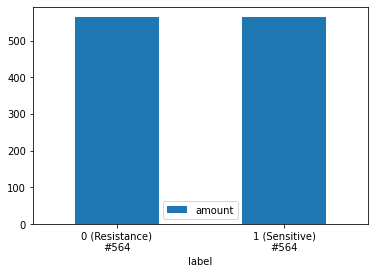

In [504]:
tttt = np.asarray(y_smo, dtype=int)
ones = np.sum(tttt)
zeros = len(tttt) - ones

df = pd.DataFrame({'label':[f'0 (Resistance)\n#{zeros}', f'1 (Sensitive)\n#{ones}'], 'amount':[zeros, ones]})

ax = df.plot.bar(x='label', y='amount', rot=0)

In [505]:
CMAP = "copper"
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
from sklearn.svm import SVC
import seaborn as sns

mvs_table = []
cts_table = []
f1s_table = []

---
### E-1. 使用 SVC 訓練 with Cross Validation

In [506]:
SVC_Model = SVC()

list_of_maximum_validation_score = []
list_of_corresponding_test_score = []
list_of_f1_score = []
list_of_features_dimension = []
overall_best_fold = -np.inf
validation_table = []
for i in range(80, 800, 30):
    ''' Feature Selection '''
    list_of_selected_features = sort_index[:i]

    selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
    FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
    selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
    FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
    # P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

    ''' SMOTE '''
    X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
    x_min, x_max = X_smo.min(0), X_smo.max(0)
    X_smo_norm = (X_smo - x_min) / (x_max - x_min)

    ''' Cross Validation '''
    kfold = StratifiedKFold(n_splits=5, shuffle=False)
    validation_score_list = []
    test_score_list = []
    f1_score_list = []

    index_of_best_fold = -np.inf
    X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)
    for train, test in kfold.split(X_smo, y_smo):
        SVC_Model.fit(X_smo[train], y_smo[train])
        score = SVC_Model.score(X_smo[test], y_smo[test])
        score = np.round_(score, decimals=4)
        validation_score_list.append(score)
        # print(f'validation_score: {score}')

        SVC_score = SVC_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
        predict = SVC_Model.predict(FeaSel_P_TCGA_D_wo_label)

        f1score = f1_score(P_TCGA_D_label, predict, average='macro')
        f1score = np.round_(f1score, decimals=4)
        f1_score_list.append(f1score)

        SVC_score = np.round_(SVC_score, decimals=4)
        test_score_list.append(SVC_score)

        if SVC_score > index_of_best_fold:
            index_of_best_fold = SVC_score
            best_train = train
            best_test = test

    validation_table.append(copy.deepcopy(validation_score_list))
    list_of_maximum_validation_score.append(np.max(validation_score_list))
    index = np.argmax(validation_score_list)
    list_of_corresponding_test_score.append(test_score_list[index])
    list_of_f1_score.append(f1_score_list[index])
    list_of_features_dimension.append(i)

    if test_score_list[index] > overall_best_fold:
        overall_best_fold = test_score_list[index]
        overall_best_train = best_train
        overall_best_test = best_test
        SVC_overall_best_i = i

print('\n')
print(list_of_maximum_validation_score)
print(list_of_corresponding_test_score)
print(list_of_f1_score)
mvs_table.append(list_of_maximum_validation_score)
cts_table.append(list_of_corresponding_test_score)
f1s_table.append(list_of_f1_score)



[0.88, 0.8894, 0.9022, 0.9156, 0.92, 0.9333, 0.9156, 0.9244, 0.9289, 0.9289, 0.92, 0.9244, 0.9111, 0.9244, 0.9333, 0.9333, 0.9378, 0.9422, 0.9292, 0.9381, 0.9378, 0.9422, 0.9422, 0.9467]
[0.5625, 0.625, 0.625, 0.625, 0.6875, 0.75, 0.75, 0.75, 0.6875, 0.6875, 0.625, 0.625, 0.625, 0.625, 0.625, 0.6875, 0.6875, 0.5625, 0.625, 0.6875, 0.6875, 0.6875, 0.625, 0.625]
[0.5608, 0.619, 0.619, 0.6, 0.6761, 0.7333, 0.7333, 0.7333, 0.6761, 0.6761, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6761, 0.6761, 0.5152, 0.6, 0.6761, 0.6761, 0.6761, 0.6, 0.6]


### K-fold cross validation (以 input features 為 80 的 SVC 為例）

In [507]:
pd_validation_table = pd.DataFrame(data=validation_table, columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
pd_validation_table = pd_validation_table.T
test = list(np.arange(80,800,30))
pd_validation_table = pd_validation_table.set_axis([test], axis=1, inplace=False)
pd_validation_table

,80,110,140,170,200,230,260,290,320,350,...,500,530,560,590,620,650,680,710,740,770
fold_1,0.7788,0.7920,0.7876,0.7788,0.7920,0.7965,0.7965,0.7876,0.7832,0.7965,...,0.8097,0.8053,0.8230,0.8097,0.8097,0.8053,0.8142,0.8230,0.8319,0.8230
fold_2,0.8186,0.8230,0.7876,0.8186,0.8274,0.8496,0.8451,0.8540,0.8540,0.8628,...,0.9027,0.8850,0.8938,0.8894,0.9115,0.9159,0.9027,0.8850,0.8761,0.8717
fold_3,0.8628,0.8894,0.8761,0.8982,0.8850,0.8894,0.8761,0.8938,0.8761,0.8894,...,0.9071,0.9248,0.9248,0.9248,0.9292,0.9381,0.9292,0.9336,0.9248,0.9204
fold_4,0.8800,0.8889,0.9022,0.9156,0.9200,0.9333,0.9156,0.9244,0.9289,0.9289,...,0.9333,0.9333,0.9378,0.9422,0.9289,0.9333,0.9378,0.9422,0.9422,0.9467
fold_5,0.8222,0.8311,0.8489,0.8311,0.8356,0.8356,0.8356,0.8400,0.8311,0.8622,...,0.8711,0.8756,0.8711,0.8756,0.8800,0.8711,0.8800,0.8889,0.8756,0.8800


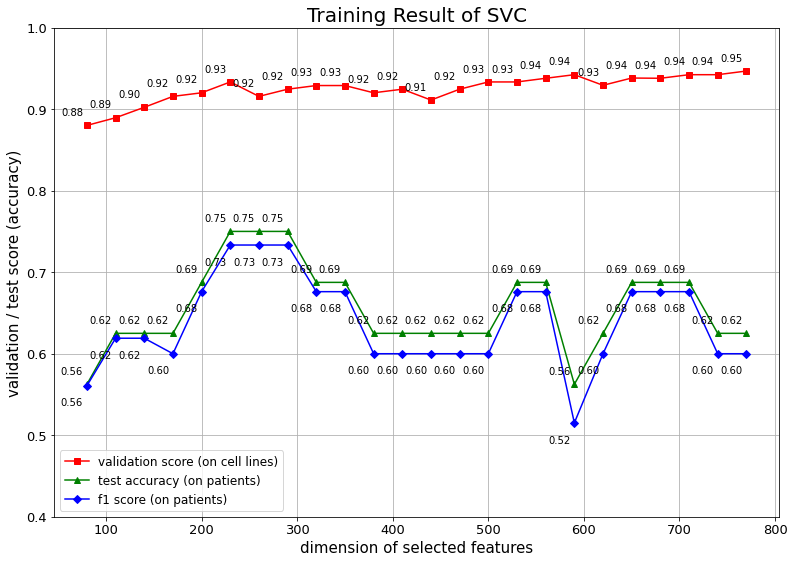

In [508]:
list_of_maximum_validation_score = np.asarray(list_of_maximum_validation_score)
list_of_corresponding_test_score = np.asarray(list_of_corresponding_test_score)
plt.figure(figsize=(13,9), linewidth=2)
plt.plot(list_of_features_dimension,
         list_of_maximum_validation_score,
         's-', color = 'r', label='validation score (on cell lines)')

plt.plot(list_of_features_dimension,
         list_of_corresponding_test_score,
         '^-', color = 'g', label='test accuracy (on patients)')

plt.plot(list_of_features_dimension,
         list_of_f1_score,
         'D-', color = 'b', label='f1 score (on patients)')

for a,b in zip(list_of_features_dimension, list_of_corresponding_test_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,10),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_maximum_validation_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,10),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_f1_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,-20),
                 ha='center')

plt.title('Training Result of SVC', fontsize=20)
plt.ylabel('validation / test score (accuracy)',fontsize=15)
plt.ylim(0.4, 1)
plt.xlabel('dimension of selected features',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.legend(loc = 'best', fontsize=12)
plt.show()

### 印出 SVC 所得最佳 test score 對應之 confusion matrix

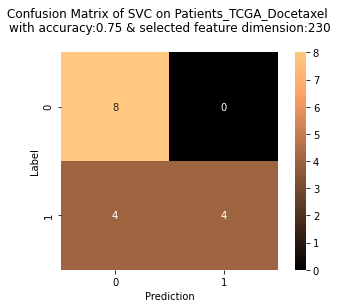

In [509]:
''' Feature Selection '''
list_of_selected_features = sort_index[:SVC_overall_best_i]

selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
# P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

''' SMOTE '''
X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
x_min, x_max = X_smo.min(0), X_smo.max(0)
X_smo_norm = (X_smo - x_min) / (x_max - x_min)
X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)

''' Draw the confusion matrix'''
SVC_Model.fit(X_smo[overall_best_train], y_smo[overall_best_train])
SVC_result = SVC_Model.predict(FeaSel_P_TCGA_D_wo_label)
SVC_accuracy = SVC_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
# test_score = SVC_Model.score(X_smo[best_test], y_smo[best_test])
SVC_cm = confusion_matrix(P_TCGA_D_label, SVC_result)
sns.heatmap(SVC_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
SVC_plot = plt.xlabel("Prediction")
SVC_plot = plt.ylabel("Label")
SVC_plot = plt.title(f"Confusion Matrix of SVC "
                     f"on Patients_TCGA_Docetaxel "
                     f"\nwith accuracy:{SVC_accuracy} & "
                     f"selected feature dimension:{SVC_overall_best_i}\n")

plt.show(SVC_plot)

---
### E-2. 使用 LightGBM 訓練 with Cross Validation

In [510]:
from lightgbm import LGBMClassifier

gbm_Model = LGBMClassifier()

list_of_maximum_validation_score = []
list_of_corresponding_test_score = []
list_of_f1_score = []
list_of_features_dimension = []
overall_best_fold = -np.inf
validation_table = []
for i in range(80, 800, 30):
    ''' Feature Selection '''
    list_of_selected_features = sort_index[:i]

    selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
    FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
    selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
    FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
    # P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

    ''' SMOTE '''
    X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
    x_min, x_max = X_smo.min(0), X_smo.max(0)
    X_smo_norm = (X_smo - x_min) / (x_max - x_min)

    ''' Cross Validation '''
    kfold = StratifiedKFold(n_splits=5, shuffle=False)
    validation_score_list = []
    test_score_list = []
    f1_score_list = []

    index_of_best_fold = -np.inf
    X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)
    for train, test in kfold.split(X_smo, y_smo):
        gbm_Model.fit(X_smo[train], y_smo[train])
        score = gbm_Model.score(X_smo[test], y_smo[test])
        score = np.round_(score, decimals=4)
        validation_score_list.append(score)
        # print(f'validation_score: {score}')

        SVC_score = gbm_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
        predict = gbm_Model.predict(FeaSel_P_TCGA_D_wo_label)

        f1score = f1_score(P_TCGA_D_label, predict, average='macro')
        f1score = np.round_(f1score, decimals=4)
        f1_score_list.append(f1score)

        SVC_score = np.round_(SVC_score, decimals=4)
        test_score_list.append(SVC_score)

        if SVC_score > index_of_best_fold:
            index_of_best_fold = SVC_score
            best_train = train
            best_test = test

    validation_table.append(copy.deepcopy(validation_score_list))
    list_of_maximum_validation_score.append(np.max(validation_score_list))
    index = np.argmax(validation_score_list)
    list_of_corresponding_test_score.append(test_score_list[index])
    list_of_f1_score.append(f1_score_list[index])
    list_of_features_dimension.append(i)

    if test_score_list[index] > overall_best_fold:
        overall_best_fold = test_score_list[index]
        overall_best_train = best_train
        overall_best_test = best_test
        gbm_overall_best_i = i

print('\n')
print(list_of_maximum_validation_score)
print(list_of_corresponding_test_score)
print(list_of_f1_score)
mvs_table.append(list_of_maximum_validation_score)
cts_table.append(list_of_corresponding_test_score)
f1s_table.append(list_of_f1_score)



[0.9378, 0.9244, 0.9422, 0.92, 0.9378, 0.9333, 0.9333, 0.9467, 0.9422, 0.9511, 0.9422, 0.9511, 0.9422, 0.9333, 0.9244, 0.9378, 0.9378, 0.9333, 0.9467, 0.9378, 0.9422, 0.9467, 0.9333, 0.9467]
[0.5, 0.5, 0.5, 0.5625, 0.5625, 0.5625, 0.625, 0.625, 0.625, 0.625, 0.5625, 0.625, 0.5625, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.625, 0.5625, 0.625]
[0.4667, 0.4182, 0.4667, 0.5152, 0.5152, 0.5152, 0.6, 0.6, 0.6, 0.5636, 0.5466, 0.6, 0.5152, 0.6761, 0.6761, 0.6537, 0.6761, 0.6761, 0.6761, 0.6761, 0.6761, 0.6, 0.5466, 0.6]


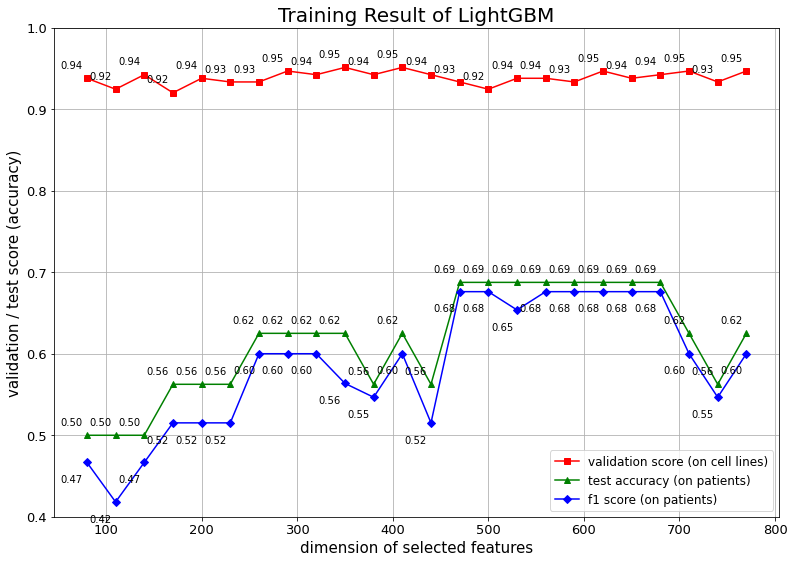

In [511]:
list_of_maximum_validation_score = np.asarray(list_of_maximum_validation_score)
list_of_corresponding_test_score = np.asarray(list_of_corresponding_test_score)
plt.figure(figsize=(13,9), linewidth=2)
plt.plot(list_of_features_dimension,
         list_of_maximum_validation_score,
         's-', color = 'r', label='validation score (on cell lines)')

plt.plot(list_of_features_dimension,
         list_of_corresponding_test_score,
         '^-', color = 'g', label='test accuracy (on patients)')

plt.plot(list_of_features_dimension,
         list_of_f1_score,
         'D-', color = 'b', label='f1 score (on patients)')

for a,b in zip(list_of_features_dimension, list_of_corresponding_test_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,10),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_maximum_validation_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,10),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_f1_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,-20),
                 ha='center')

plt.title('Training Result of LightGBM', fontsize=20)
plt.ylabel('validation / test score (accuracy)',fontsize=15)
plt.ylim(0.4, 1)
plt.xlabel('dimension of selected features',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.legend(loc = 'best', fontsize=12)
plt.show()


### 印出 LighGBM 所得最佳 test score 對應之 confusion matrix

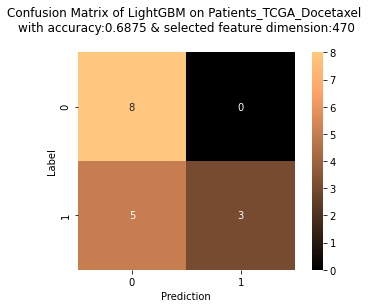

In [512]:
''' Feature Selection '''
list_of_selected_features = sort_index[:gbm_overall_best_i]

selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
# P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

''' SMOTE '''
X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
x_min, x_max = X_smo.min(0), X_smo.max(0)
X_smo_norm = (X_smo - x_min) / (x_max - x_min)
X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)

''' Draw the confusion matrix'''
gbm_Model.fit(X_smo[overall_best_train], y_smo[overall_best_train])
SVC_result = gbm_Model.predict(FeaSel_P_TCGA_D_wo_label)
gbm_accuracy = gbm_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
# test_score = SVC_Model.score(X_smo[best_test], y_smo[best_test])
SVC_cm = confusion_matrix(P_TCGA_D_label, SVC_result)
sns.heatmap(SVC_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
SVC_plot = plt.xlabel("Prediction")
SVC_plot = plt.ylabel("Label")
SVC_plot = plt.title(f"Confusion Matrix of LightGBM "
                     f"on Patients_TCGA_Docetaxel "
                     f"\nwith accuracy:{gbm_accuracy} & "
                     f"selected feature dimension:{gbm_overall_best_i}\n")
plt.show(SVC_plot)

---
### E-3. 使用 KNN 訓練 with Cross Validation

In [513]:
from sklearn.neighbors import KNeighborsClassifier
KNN_Model = KNeighborsClassifier(n_neighbors=5)


list_of_maximum_validation_score = []
list_of_corresponding_test_score = []
list_of_f1_score = []
list_of_features_dimension = []
overall_best_fold = -np.inf
validation_table = []
for i in range(80, 800, 30):
    ''' Feature Selection '''
    list_of_selected_features = sort_index[:i]

    selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
    FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
    selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
    FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
    # P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

    ''' SMOTE '''
    X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
    x_min, x_max = X_smo.min(0), X_smo.max(0)
    X_smo_norm = (X_smo - x_min) / (x_max - x_min)

    ''' Cross Validation '''
    kfold = StratifiedKFold(n_splits=5, shuffle=False)
    validation_score_list = []
    test_score_list = []
    f1_score_list = []

    index_of_best_fold = -np.inf
    X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)
    for train, test in kfold.split(X_smo, y_smo):
        KNN_Model.fit(X_smo[train], y_smo[train])
        score = KNN_Model.score(X_smo[test], y_smo[test])
        score = np.round_(score, decimals=4)
        validation_score_list.append(score)
        # print(f'validation_score: {score}')

        SVC_score = KNN_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
        predict = KNN_Model.predict(FeaSel_P_TCGA_D_wo_label)

        f1score = f1_score(P_TCGA_D_label, predict, average='macro')
        f1score = np.round_(f1score, decimals=4)
        f1_score_list.append(f1score)

        SVC_score = np.round_(SVC_score, decimals=4)
        test_score_list.append(SVC_score)

        if SVC_score > index_of_best_fold:
            index_of_best_fold = SVC_score
            best_train = train
            best_test = test

    validation_table.append(copy.deepcopy(validation_score_list))
    list_of_maximum_validation_score.append(np.max(validation_score_list))
    index = np.argmax(validation_score_list)
    list_of_corresponding_test_score.append(test_score_list[index])
    list_of_f1_score.append(f1_score_list[index])
    list_of_features_dimension.append(i)

    if test_score_list[index] > overall_best_fold:
        overall_best_fold = test_score_list[index]
        overall_best_train = best_train
        overall_best_test = best_test
        KNN_overall_best_i = i

print('\n')
print(list_of_maximum_validation_score)
print(list_of_corresponding_test_score)
print(list_of_f1_score)
mvs_table.append(list_of_maximum_validation_score)
cts_table.append(list_of_corresponding_test_score)
f1s_table.append(list_of_f1_score)



[0.7511, 0.7644, 0.7467, 0.7689, 0.7822, 0.7556, 0.7822, 0.7867, 0.7467, 0.7644, 0.7467, 0.7378, 0.7289, 0.7156, 0.7289, 0.72, 0.7022, 0.7067, 0.7378, 0.7156, 0.72, 0.7289, 0.7156, 0.6933]
[0.6875, 0.625, 0.5, 0.5625, 0.625, 0.5, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.625, 0.625, 0.625, 0.6875, 0.5625, 0.5625, 0.5625, 0.625, 0.5625, 0.5625, 0.5, 0.5, 0.5]
[0.6537, 0.6, 0.4921, 0.5152, 0.6, 0.4667, 0.5152, 0.5152, 0.5152, 0.5152, 0.4589, 0.5636, 0.5636, 0.5636, 0.6537, 0.4589, 0.4589, 0.4589, 0.5636, 0.4589, 0.4589, 0.4182, 0.4182, 0.4182]


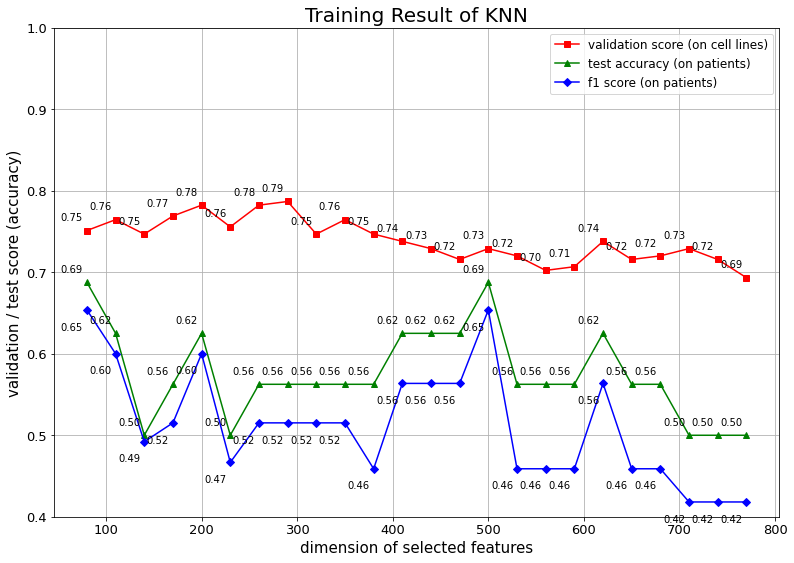

In [514]:
list_of_maximum_validation_score = np.asarray(list_of_maximum_validation_score)
list_of_corresponding_test_score = np.asarray(list_of_corresponding_test_score)
plt.figure(figsize=(13,9), linewidth=2)
plt.plot(list_of_features_dimension,
         list_of_maximum_validation_score,
         's-', color = 'r', label='validation score (on cell lines)')

plt.plot(list_of_features_dimension,
         list_of_corresponding_test_score,
         '^-', color = 'g', label='test accuracy (on patients)')

plt.plot(list_of_features_dimension,
         list_of_f1_score,
         'D-', color = 'b', label='f1 score (on patients)')

for a,b in zip(list_of_features_dimension, list_of_corresponding_test_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,10),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_maximum_validation_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,10),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_f1_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,-20),
                 ha='center')

plt.title('Training Result of KNN', fontsize=20)
plt.ylabel('validation / test score (accuracy)',fontsize=15)
plt.ylim(0.4, 1)
plt.xlabel('dimension of selected features',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.legend(loc = 'best', fontsize=12)
plt.show()


### 印出 KNN 所得最佳 test score 對應之 confusion matrix

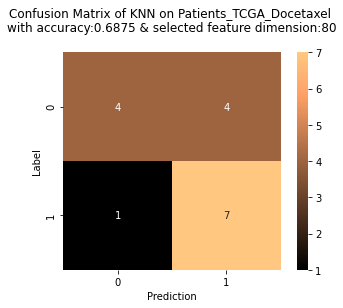

In [515]:
''' Feature Selection '''
list_of_selected_features = sort_index[:KNN_overall_best_i]

selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
# P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

''' SMOTE '''
X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
x_min, x_max = X_smo.min(0), X_smo.max(0)
X_smo_norm = (X_smo - x_min) / (x_max - x_min)
X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)

''' Draw the confusion matrix'''
KNN_Model.fit(X_smo[overall_best_train], y_smo[overall_best_train])
SVC_result = KNN_Model.predict(FeaSel_P_TCGA_D_wo_label)
KNN_accuracy = KNN_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
# test_score = KNN_Model.score(X_smo[best_test], y_smo[best_test])
SVC_cm = confusion_matrix(P_TCGA_D_label, SVC_result)
sns.heatmap(SVC_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
SVC_plot = plt.xlabel("Prediction")
SVC_plot = plt.ylabel("Label")
SVC_plot = plt.title(f"Confusion Matrix of KNN "
                     f"on Patients_TCGA_Docetaxel "
                     f"\nwith accuracy:{KNN_accuracy} & "
                     f"selected feature dimension:{KNN_overall_best_i}\n")
plt.show(SVC_plot)

---
### E-4. 使用 Naive Bayes 訓練 with Cross Validation

In [516]:
from sklearn.naive_bayes import GaussianNB
NB_Model = GaussianNB()


list_of_maximum_validation_score = []
list_of_corresponding_test_score = []
list_of_f1_score = []
list_of_features_dimension = []
overall_best_fold = -np.inf
validation_table = []
for i in range(80, 800, 30):
    ''' Feature Selection '''
    list_of_selected_features = sort_index[:i]

    selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
    FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
    selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
    FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
    # P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

    ''' SMOTE '''
    X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
    x_min, x_max = X_smo.min(0), X_smo.max(0)
    X_smo_norm = (X_smo - x_min) / (x_max - x_min)

    ''' Cross Validation '''
    kfold = StratifiedKFold(n_splits=5, shuffle=False)
    validation_score_list = []
    test_score_list = []
    f1_score_list = []

    index_of_best_fold = -np.inf
    X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)
    for train, test in kfold.split(X_smo, y_smo):
        NB_Model.fit(X_smo[train], y_smo[train])
        score = NB_Model.score(X_smo[test], y_smo[test])
        score = np.round_(score, decimals=4)
        validation_score_list.append(score)
        # print(f'validation_score: {score}')

        SVC_score = NB_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
        predict = NB_Model.predict(FeaSel_P_TCGA_D_wo_label)

        f1score = f1_score(P_TCGA_D_label, predict, average='macro')
        f1score = np.round_(f1score, decimals=4)
        f1_score_list.append(f1score)

        SVC_score = np.round_(SVC_score, decimals=4)
        test_score_list.append(SVC_score)

        if SVC_score > index_of_best_fold:
            index_of_best_fold = SVC_score
            best_train = train
            best_test = test

    validation_table.append(copy.deepcopy(validation_score_list))
    list_of_maximum_validation_score.append(np.max(validation_score_list))
    index = np.argmax(validation_score_list)
    list_of_corresponding_test_score.append(test_score_list[index])
    list_of_f1_score.append(f1_score_list[index])
    list_of_features_dimension.append(i)

    if test_score_list[index] > overall_best_fold:
        overall_best_fold = test_score_list[index]
        overall_best_train = best_train
        overall_best_test = best_test
        NB_overall_best_i = i

print('\n')
print(list_of_maximum_validation_score)
print(list_of_corresponding_test_score)
print(list_of_f1_score)
mvs_table.append(list_of_maximum_validation_score)
cts_table.append(list_of_corresponding_test_score)
f1s_table.append(list_of_f1_score)



[0.7257, 0.7301, 0.7111, 0.7378, 0.72, 0.7467, 0.7212, 0.7212, 0.6991, 0.7124, 0.7301, 0.7212, 0.7389, 0.7434, 0.7301, 0.7478, 0.7566, 0.7378, 0.7378, 0.7467, 0.7389, 0.7345, 0.7301, 0.7257]
[0.5625, 0.5625, 0.4375, 0.625, 0.5625, 0.5625, 0.625, 0.625, 0.6875, 0.6875, 0.6875, 0.625, 0.5, 0.6875, 0.6875, 0.625, 0.625, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.6875]
[0.5466, 0.5608, 0.4353, 0.619, 0.5466, 0.5466, 0.619, 0.619, 0.6761, 0.6761, 0.6761, 0.619, 0.4921, 0.6761, 0.6761, 0.6, 0.619, 0.6537, 0.6537, 0.6537, 0.6537, 0.6537, 0.6537, 0.6537]


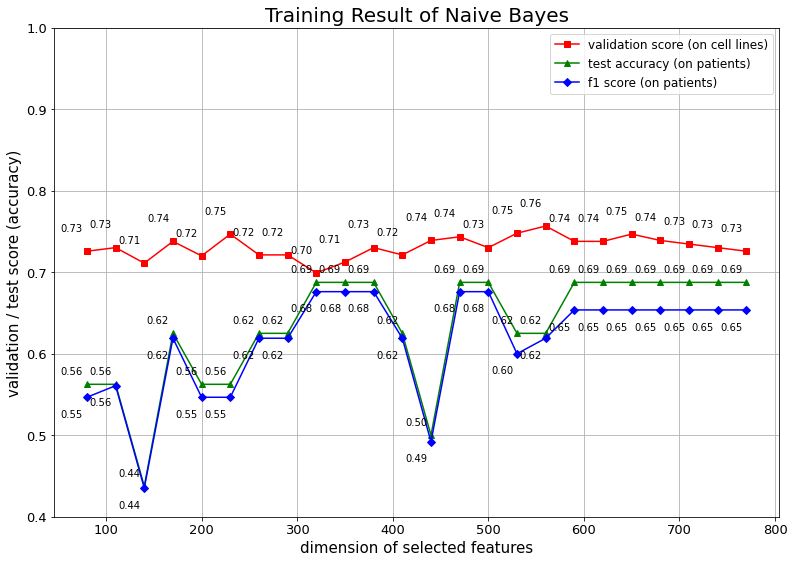

In [517]:
list_of_maximum_validation_score = np.asarray(list_of_maximum_validation_score)
list_of_corresponding_test_score = np.asarray(list_of_corresponding_test_score)
plt.figure(figsize=(13,9), linewidth=2)
plt.plot(list_of_features_dimension,
         list_of_maximum_validation_score,
         's-', color = 'r', label='validation score (on cell lines)')

plt.plot(list_of_features_dimension,
         list_of_corresponding_test_score,
         '^-', color = 'g', label='test accuracy (on patients)')

plt.plot(list_of_features_dimension,
         list_of_f1_score,
         'D-', color = 'b', label='f1 score (on patients)')

for a,b in zip(list_of_features_dimension, list_of_corresponding_test_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,10),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_maximum_validation_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,20),
                 ha='center')

for a,b in zip(list_of_features_dimension, list_of_f1_score):
    label = "{:.2f}".format(b)
    plt.annotate(label,
                 (a, b),
                 textcoords="offset pixels",
                 xytext=(-15,-20),
                 ha='center')

plt.title('Training Result of Naive Bayes', fontsize=20)
plt.ylabel('validation / test score (accuracy)',fontsize=15)
plt.ylim(0.4, 1)
plt.xlabel('dimension of selected features',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.legend(loc = 'best', fontsize=12)
plt.show()

### 印出 Naive Bayes 所得最佳 test score 對應之 confusion matrix

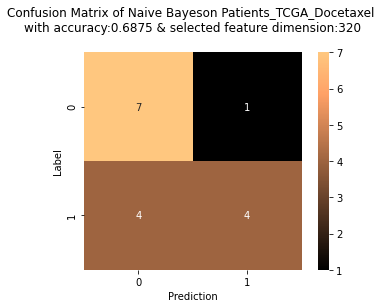

In [518]:
''' Feature Selection '''
list_of_selected_features = sort_index[:NB_overall_best_i]

selected_columns = GDSC_TCGA_D_train_data.columns[list_of_selected_features]
FeaSel_GDSC_TCGA_D_train_data = GDSC_TCGA_D_train_data[selected_columns]
selected_columns = P_TCGA_D_wo_label.columns[list_of_selected_features]
FeaSel_P_TCGA_D_wo_label = P_TCGA_D_wo_label[selected_columns]
# P_TCGA_D_wo_label = P_TCGA_D_wo_label[P_TCGA_D_wo_label.columns[list_of_selected_features]]

''' SMOTE '''
X_smo, y_smo = smote.fit_resample(FeaSel_GDSC_TCGA_D_train_data, GDSC_TCGA_D_train_data_label)
x_min, x_max = X_smo.min(0), X_smo.max(0)
X_smo_norm = (X_smo - x_min) / (x_max - x_min)
X_smo = np.asarray(X_smo); y_smo = np.asarray(y_smo)

''' Draw the confusion matrix'''
NB_Model.fit(X_smo[overall_best_train], y_smo[overall_best_train])
SVC_result = NB_Model.predict(FeaSel_P_TCGA_D_wo_label)
NB_accuracy = NB_Model.score(FeaSel_P_TCGA_D_wo_label, P_TCGA_D_label)
# test_score = NB_Model.score(X_smo[best_test], y_smo[best_test])
SVC_cm = confusion_matrix(P_TCGA_D_label, SVC_result)
sns.heatmap(SVC_cm, square=True, annot=True, cmap=CMAP, cbar=True, fmt="")
SVC_plot = plt.xlabel("Prediction")
SVC_plot = plt.ylabel("Label")
SVC_plot = plt.title(f"Confusion Matrix of Naive Bayes"
                     f"on Patients_TCGA_Docetaxel "
                     f"\nwith accuracy:{NB_accuracy} & "
                     f"selected feature dimension:{NB_overall_best_i}\n")
plt.show(SVC_plot)

### 列印出 四個 algorithms 的 validation score, test score & f1 score

In [519]:
mvs_table = np.asarray(mvs_table)
mvs_table_transpose = mvs_table.T
cts_table = np.asarray(cts_table)
cts_table_transpose = cts_table.T
f1s_table = np.asarray(f1s_table)
f1s_table_transpose = f1s_table.T

In [520]:
pd_validation_table = pd.DataFrame(data=mvs_table_transpose, columns=['SVC', 'LightGBM', 'KNN', 'Naive_Bayes'])
pd_validation_table = pd_validation_table.T
test = list(np.arange(80,800,30))
pd_validation_table = pd_validation_table.set_axis([test], axis=1, inplace=False)
pd_validation_table


,80,110,140,170,200,230,260,290,320,350,...,500,530,560,590,620,650,680,710,740,770
SVC,0.8800,0.8894,0.9022,0.9156,0.9200,0.9333,0.9156,0.9244,0.9289,0.9289,...,0.9333,0.9333,0.9378,0.9422,0.9292,0.9381,0.9378,0.9422,0.9422,0.9467
LightGBM,0.9378,0.9244,0.9422,0.9200,0.9378,0.9333,0.9333,0.9467,0.9422,0.9511,...,0.9244,0.9378,0.9378,0.9333,0.9467,0.9378,0.9422,0.9467,0.9333,0.9467
KNN,0.7511,0.7644,0.7467,0.7689,0.7822,0.7556,0.7822,0.7867,0.7467,0.7644,...,0.7289,0.7200,0.7022,0.7067,0.7378,0.7156,0.7200,0.7289,0.7156,0.6933
Naive_Bayes,0.7257,0.7301,0.7111,0.7378,0.7200,0.7467,0.7212,0.7212,0.6991,0.7124,...,0.7301,0.7478,0.7566,0.7378,0.7378,0.7467,0.7389,0.7345,0.7301,0.7257


In [521]:
pd_test_table = pd.DataFrame(data=cts_table_transpose, columns=['SVC', 'LightGBM', 'KNN', 'Naive_Bayes'])
pd_test_table = pd_test_table.T
test = list(np.arange(80,800,30))
pd_test_table = pd_test_table.set_axis([test], axis=1, inplace=False)
pd_test_table

,80,110,140,170,200,230,260,290,320,350,...,500,530,560,590,620,650,680,710,740,770
SVC,0.5625,0.6250,0.6250,0.6250,0.6875,0.7500,0.7500,0.7500,0.6875,0.6875,...,0.6250,0.6875,0.6875,0.5625,0.6250,0.6875,0.6875,0.6875,0.6250,0.6250
LightGBM,0.5000,0.5000,0.5000,0.5625,0.5625,0.5625,0.6250,0.6250,0.6250,0.6250,...,0.6875,0.6875,0.6875,0.6875,0.6875,0.6875,0.6875,0.6250,0.5625,0.6250
KNN,0.6875,0.6250,0.5000,0.5625,0.6250,0.5000,0.5625,0.5625,0.5625,0.5625,...,0.6875,0.5625,0.5625,0.5625,0.6250,0.5625,0.5625,0.5000,0.5000,0.5000
Naive_Bayes,0.5625,0.5625,0.4375,0.6250,0.5625,0.5625,0.6250,0.6250,0.6875,0.6875,...,0.6875,0.6250,0.6250,0.6875,0.6875,0.6875,0.6875,0.6875,0.6875,0.6875


In [522]:
pd_f1_score_table = pd.DataFrame(data=f1s_table_transpose, columns=['SVC', 'LightGBM', 'KNN', 'Naive_Bayes'])
pd_f1_score_table = pd_f1_score_table.T
test = list(np.arange(80,800,30))
pd_f1_score_table = pd_f1_score_table.set_axis([test], axis=1, inplace=False)
pd_f1_score_table

,80,110,140,170,200,230,260,290,320,350,...,500,530,560,590,620,650,680,710,740,770
SVC,0.5608,0.6190,0.6190,0.6000,0.6761,0.7333,0.7333,0.7333,0.6761,0.6761,...,0.6000,0.6761,0.6761,0.5152,0.6000,0.6761,0.6761,0.6761,0.6000,0.6000
LightGBM,0.4667,0.4182,0.4667,0.5152,0.5152,0.5152,0.6000,0.6000,0.6000,0.5636,...,0.6761,0.6537,0.6761,0.6761,0.6761,0.6761,0.6761,0.6000,0.5466,0.6000
KNN,0.6537,0.6000,0.4921,0.5152,0.6000,0.4667,0.5152,0.5152,0.5152,0.5152,...,0.6537,0.4589,0.4589,0.4589,0.5636,0.4589,0.4589,0.4182,0.4182,0.4182
Naive_Bayes,0.5466,0.5608,0.4353,0.6190,0.5466,0.5466,0.6190,0.6190,0.6761,0.6761,...,0.6761,0.6000,0.6190,0.6537,0.6537,0.6537,0.6537,0.6537,0.6537,0.6537
